# Generate Art using DCGANs in Pytorch 

## Task 1 : Project Overview and Import Libraries

In [1]:
import os
import torch
import torchvision
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import torchvision.models as models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchvision.datasets.folder import default_loader
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!pip install opendatasets --upgrade --quiet

In [3]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/ikarus777/best-artworks-of-all-time'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  vishnunair17


Your Kaggle Key:

  ································


100%|██████████| 2.29G/2.29G [01:49<00:00, 22.4MB/s]


In [4]:
import os

DATA_DIR = './best-artworks-of-all-time'
print(os.listdir(DATA_DIR))

['resized', 'images', 'artists.csv']


## Task 2 :Preparing the data 

In [5]:
artists = pd.read_csv("best-artworks-of-all-time/artists.csv")

for i in artists['name']:
    print(i,end=" | ")

Amedeo Modigliani | Vasiliy Kandinskiy | Diego Rivera | Claude Monet | Rene Magritte | Salvador Dali | Edouard Manet | Andrei Rublev | Vincent van Gogh | Gustav Klimt | Hieronymus Bosch | Kazimir Malevich | Mikhail Vrubel | Pablo Picasso | Peter Paul Rubens | Pierre-Auguste Renoir | Francisco Goya | Frida Kahlo | El Greco | Albrecht Dürer | Alfred Sisley | Pieter Bruegel | Marc Chagall | Giotto di Bondone | Sandro Botticelli | Caravaggio | Leonardo da Vinci | Diego Velazquez | Henri Matisse | Jan van Eyck | Edgar Degas | Rembrandt | Titian | Henri de Toulouse-Lautrec | Gustave Courbet | Camille Pissarro | William Turner | Edvard Munch | Paul Cezanne | Eugene Delacroix | Henri Rousseau | Georges Seurat | Paul Klee | Piet Mondrian | Joan Miro | Andy Warhol | Paul Gauguin | Raphael | Michelangelo | Jackson Pollock | 

In [6]:
batch_size = 128
image_size = (64,64)
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [7]:
transform_ds = transforms.Compose([transforms.Resize(image_size),
#                                    transforms.RandomCrop(32, padding=2),
#                                    transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                                   transforms.Normalize(*stats)
                                   ])

train_ds = torchvision.datasets.ImageFolder(root="best-artworks-of-all-time/resized",
                                     transform=transform_ds)

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
print(len(train_ds))

8683


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 64, 64])


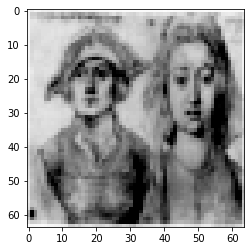

In [8]:
images,_ = train_ds[382]
print(images.size())
plt.imshow(images.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


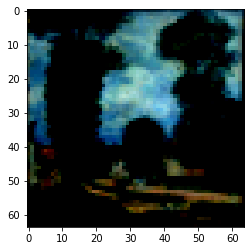

In [9]:
images,_ = train_ds[872]
plt.imshow(images.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


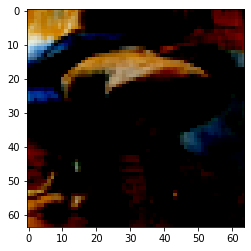

In [10]:
images,_ = train_ds[1912]
plt.imshow(images.permute(1,2,0))


In [11]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [12]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

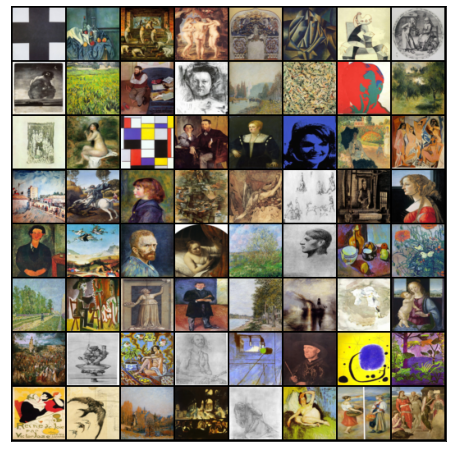

In [13]:
show_batch(train_dl)

In [14]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [15]:
device = get_default_device()
device

device(type='cuda')

In [16]:
train_dl = DeviceDataLoader(train_dl, device)

In [17]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [18]:
discriminator = to_device(discriminator, device)

In [19]:
latent_size = 150

In [20]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


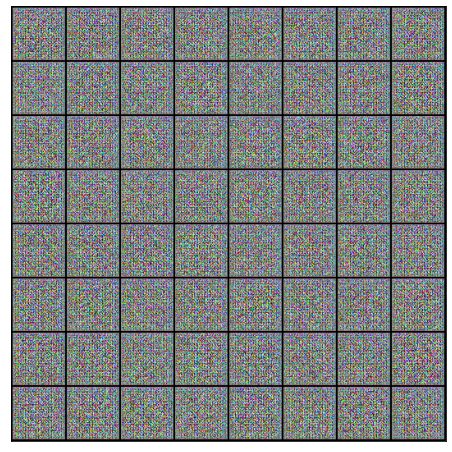

In [21]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

## Task 3 :Defining the model

In [22]:
generator = to_device(generator, device)

In [23]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [24]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [25]:
from torchvision.utils import save_image

In [26]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [27]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [28]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


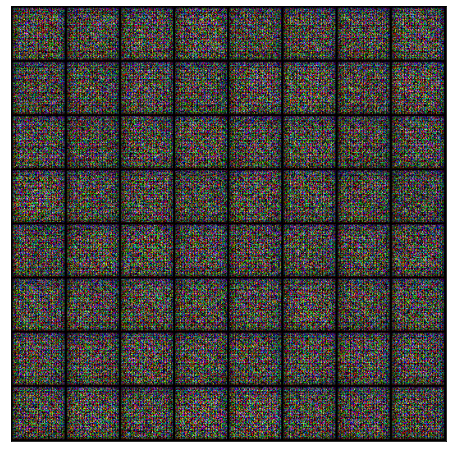

In [29]:
save_samples(0, fixed_latent)

In [30]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [31]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [32]:
lr = 0.001
epochs = 100

In [ ]:
history = fit(epochs,lr)

  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [1/100], loss_g: 4.3809, loss_d: 0.7440, real_score: 0.9312, fake_score: 0.4283
Saving generated-images-0001.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 5.1622, loss_d: 1.0388, real_score: 0.9237, fake_score: 0.5354
Saving generated-images-0002.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 2.3367, loss_d: 0.3285, real_score: 0.8363, fake_score: 0.1271
Saving generated-images-0003.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 3.1775, loss_d: 0.8727, real_score: 0.8091, fake_score: 0.4498
Saving generated-images-0004.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 1.2404, loss_d: 1.6866, real_score: 0.9159, fake_score: 0.7610
Saving generated-images-0005.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 2.2199, loss_d: 0.8763, real_score: 0.7370, fake_score: 0.3730
Saving generated-images-0006.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 1.9464, loss_d: 1.0866, real_score: 0.5672, fake_score: 0.3369
Saving generated-images-0007.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 2.6964, loss_d: 0.8125, real_score: 0.6495, fake_score: 0.2577
Saving generated-images-0008.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 1.9861, loss_d: 1.9308, real_score: 0.2099, fake_score: 0.0550
Saving generated-images-0009.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 3.5278, loss_d: 0.6082, real_score: 0.8864, fake_score: 0.3515
Saving generated-images-0010.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 1.9222, loss_d: 0.7304, real_score: 0.6875, fake_score: 0.2544
Saving generated-images-0011.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 3.5582, loss_d: 0.6199, real_score: 0.8564, fake_score: 0.3487
Saving generated-images-0012.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 2.6545, loss_d: 0.6136, real_score: 0.7397, fake_score: 0.2290
Saving generated-images-0013.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 3.4032, loss_d: 0.3455, real_score: 0.9093, fake_score: 0.2038
Saving generated-images-0014.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 3.5434, loss_d: 1.2112, real_score: 0.7896, fake_score: 0.5701
Saving generated-images-0015.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 4.0747, loss_d: 0.5873, real_score: 0.8200, fake_score: 0.2845
Saving generated-images-0016.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 3.1310, loss_d: 1.0634, real_score: 0.8801, fake_score: 0.5670
Saving generated-images-0017.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 2.7744, loss_d: 0.4007, real_score: 0.7630, fake_score: 0.0876
Saving generated-images-0018.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 4.6576, loss_d: 0.2600, real_score: 0.8494, fake_score: 0.0737
Saving generated-images-0019.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 3.9355, loss_d: 0.8135, real_score: 0.9077, fake_score: 0.4464
Saving generated-images-0020.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 3.9976, loss_d: 0.5289, real_score: 0.8140, fake_score: 0.2433
Saving generated-images-0021.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 3.4762, loss_d: 1.0299, real_score: 0.8302, fake_score: 0.5142
Saving generated-images-0022.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 3.5169, loss_d: 0.8200, real_score: 0.7543, fake_score: 0.3199
Saving generated-images-0023.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 4.0505, loss_d: 0.3305, real_score: 0.7954, fake_score: 0.0755
Saving generated-images-0024.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 6.9243, loss_d: 0.7932, real_score: 0.9292, fake_score: 0.4524
Saving generated-images-0025.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 4.6851, loss_d: 0.5862, real_score: 0.9270, fake_score: 0.3487
Saving generated-images-0026.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 4.7397, loss_d: 0.7273, real_score: 0.8738, fake_score: 0.3635
Saving generated-images-0027.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 2.5502, loss_d: 0.4546, real_score: 0.8555, fake_score: 0.2115
Saving generated-images-0028.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 4.6436, loss_d: 0.5092, real_score: 0.6767, fake_score: 0.0436
Saving generated-images-0029.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 2.8191, loss_d: 0.5453, real_score: 0.8501, fake_score: 0.2777
Saving generated-images-0030.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 4.1259, loss_d: 0.6666, real_score: 0.8045, fake_score: 0.3143
Saving generated-images-0031.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 1.7493, loss_d: 1.5633, real_score: 0.3104, fake_score: 0.0541
Saving generated-images-0032.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 2.7136, loss_d: 0.6682, real_score: 0.6559, fake_score: 0.1518
Saving generated-images-0033.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 6.4376, loss_d: 1.3234, real_score: 0.8980, fake_score: 0.6390
Saving generated-images-0034.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 2.2570, loss_d: 0.6155, real_score: 0.8595, fake_score: 0.3041
Saving generated-images-0035.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 4.3285, loss_d: 0.9834, real_score: 0.9316, fake_score: 0.5127
Saving generated-images-0036.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 5.3205, loss_d: 1.0826, real_score: 0.8294, fake_score: 0.5162
Saving generated-images-0037.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 4.5092, loss_d: 0.3690, real_score: 0.9128, fake_score: 0.2073
Saving generated-images-0038.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 4.6064, loss_d: 1.7637, real_score: 0.7466, fake_score: 0.4740
Saving generated-images-0039.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 2.5374, loss_d: 0.6089, real_score: 0.7305, fake_score: 0.2082
Saving generated-images-0040.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [41/100], loss_g: 4.5126, loss_d: 0.9122, real_score: 0.8362, fake_score: 0.4481
Saving generated-images-0041.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [42/100], loss_g: 3.4025, loss_d: 0.5757, real_score: 0.8436, fake_score: 0.2984
Saving generated-images-0042.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [43/100], loss_g: 3.2340, loss_d: 0.4866, real_score: 0.7564, fake_score: 0.1424
Saving generated-images-0043.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [44/100], loss_g: 1.7972, loss_d: 0.8104, real_score: 0.5930, fake_score: 0.1290
Saving generated-images-0044.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [45/100], loss_g: 3.8797, loss_d: 0.6342, real_score: 0.8594, fake_score: 0.3436
Saving generated-images-0045.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [46/100], loss_g: 3.1817, loss_d: 0.6557, real_score: 0.8385, fake_score: 0.3169
Saving generated-images-0046.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [47/100], loss_g: 8.8128, loss_d: 2.5954, real_score: 0.9745, fake_score: 0.8443
Saving generated-images-0047.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [48/100], loss_g: 5.1643, loss_d: 0.8887, real_score: 0.9688, fake_score: 0.4945
Saving generated-images-0048.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [49/100], loss_g: 4.9709, loss_d: 0.8865, real_score: 0.9561, fake_score: 0.4920
Saving generated-images-0049.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [50/100], loss_g: 4.3496, loss_d: 0.5900, real_score: 0.8986, fake_score: 0.3290
Saving generated-images-0050.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [51/100], loss_g: 4.5940, loss_d: 0.6544, real_score: 0.9255, fake_score: 0.3668
Saving generated-images-0051.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [52/100], loss_g: 4.0677, loss_d: 0.4790, real_score: 0.8154, fake_score: 0.1816
Saving generated-images-0052.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [53/100], loss_g: 3.4498, loss_d: 0.2942, real_score: 0.8594, fake_score: 0.1069
Saving generated-images-0053.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [54/100], loss_g: 4.7314, loss_d: 0.5378, real_score: 0.9416, fake_score: 0.3213
Saving generated-images-0054.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [55/100], loss_g: 3.2902, loss_d: 0.6230, real_score: 0.6816, fake_score: 0.1230
Saving generated-images-0055.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [56/100], loss_g: 2.5609, loss_d: 0.6735, real_score: 0.6814, fake_score: 0.1913
Saving generated-images-0056.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [57/100], loss_g: 3.1138, loss_d: 0.6884, real_score: 0.6070, fake_score: 0.0723
Saving generated-images-0057.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [58/100], loss_g: 3.8928, loss_d: 0.5570, real_score: 0.9799, fake_score: 0.3529
Saving generated-images-0058.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [59/100], loss_g: 4.4606, loss_d: 0.4128, real_score: 0.8740, fake_score: 0.2157
Saving generated-images-0059.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [60/100], loss_g: 5.9254, loss_d: 0.9701, real_score: 0.9721, fake_score: 0.5181
Saving generated-images-0060.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [61/100], loss_g: 4.4732, loss_d: 0.7072, real_score: 0.9092, fake_score: 0.3712
Saving generated-images-0061.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [62/100], loss_g: 4.3750, loss_d: 0.2186, real_score: 0.9239, fake_score: 0.1139
Saving generated-images-0062.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [63/100], loss_g: 3.2418, loss_d: 0.6149, real_score: 0.8251, fake_score: 0.2749
Saving generated-images-0063.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [64/100], loss_g: 3.0211, loss_d: 0.4432, real_score: 0.7773, fake_score: 0.0936
Saving generated-images-0064.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [65/100], loss_g: 3.9001, loss_d: 0.6857, real_score: 0.8572, fake_score: 0.3256
Saving generated-images-0065.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [66/100], loss_g: 4.2209, loss_d: 0.5035, real_score: 0.9498, fake_score: 0.3185
Saving generated-images-0066.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [67/100], loss_g: 0.8195, loss_d: 0.5935, real_score: 0.6408, fake_score: 0.0596
Saving generated-images-0067.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [68/100], loss_g: 4.9738, loss_d: 1.0967, real_score: 0.9590, fake_score: 0.5406
Saving generated-images-0068.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [69/100], loss_g: 2.4430, loss_d: 0.4748, real_score: 0.7560, fake_score: 0.1092
Saving generated-images-0069.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [70/100], loss_g: 5.1249, loss_d: 0.6963, real_score: 0.9305, fake_score: 0.4055
Saving generated-images-0070.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [71/100], loss_g: 2.7643, loss_d: 0.4606, real_score: 0.7830, fake_score: 0.1245
Saving generated-images-0071.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [72/100], loss_g: 1.7434, loss_d: 0.6327, real_score: 0.6318, fake_score: 0.0643
Saving generated-images-0072.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [73/100], loss_g: 6.1833, loss_d: 1.1809, real_score: 0.9830, fake_score: 0.5568
Saving generated-images-0073.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [74/100], loss_g: 2.3409, loss_d: 0.4817, real_score: 0.9073, fake_score: 0.2660
Saving generated-images-0074.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [75/100], loss_g: 3.5853, loss_d: 0.5253, real_score: 0.9453, fake_score: 0.3241
Saving generated-images-0075.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [76/100], loss_g: 4.9426, loss_d: 1.2222, real_score: 0.9560, fake_score: 0.5610
Saving generated-images-0076.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [77/100], loss_g: 3.4127, loss_d: 0.3101, real_score: 0.8490, fake_score: 0.1133
Saving generated-images-0077.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [78/100], loss_g: 4.7077, loss_d: 0.7137, real_score: 0.8629, fake_score: 0.2766
Saving generated-images-0078.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [79/100], loss_g: 3.2435, loss_d: 0.5478, real_score: 0.8592, fake_score: 0.2569
Saving generated-images-0079.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [80/100], loss_g: 1.8732, loss_d: 1.3837, real_score: 0.3949, fake_score: 0.0314
Saving generated-images-0080.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [81/100], loss_g: 3.3826, loss_d: 0.5068, real_score: 0.8533, fake_score: 0.2326
Saving generated-images-0081.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [82/100], loss_g: 5.1970, loss_d: 0.2487, real_score: 0.8621, fake_score: 0.0341
Saving generated-images-0082.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [83/100], loss_g: 4.3896, loss_d: 0.2247, real_score: 0.9292, fake_score: 0.1231
Saving generated-images-0083.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [84/100], loss_g: 4.6568, loss_d: 0.1255, real_score: 0.9426, fake_score: 0.0528
Saving generated-images-0084.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [85/100], loss_g: 3.0597, loss_d: 1.2377, real_score: 0.5681, fake_score: 0.0596
Saving generated-images-0085.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [86/100], loss_g: 4.3387, loss_d: 0.1610, real_score: 0.9089, fake_score: 0.0316
Saving generated-images-0086.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [87/100], loss_g: 5.9710, loss_d: 0.1646, real_score: 0.8792, fake_score: 0.0230
Saving generated-images-0087.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [88/100], loss_g: 0.9636, loss_d: 0.4729, real_score: 0.7141, fake_score: 0.0495
Saving generated-images-0088.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [89/100], loss_g: 1.9961, loss_d: 0.4887, real_score: 0.6927, fake_score: 0.0358
Saving generated-images-0089.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [90/100], loss_g: 4.9689, loss_d: 0.1293, real_score: 0.9276, fake_score: 0.0438
Saving generated-images-0090.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [91/100], loss_g: 4.7252, loss_d: 0.5408, real_score: 0.9518, fake_score: 0.2970
Saving generated-images-0091.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [92/100], loss_g: 4.4933, loss_d: 0.2153, real_score: 0.8952, fake_score: 0.0777
Saving generated-images-0092.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [93/100], loss_g: 4.0092, loss_d: 0.1871, real_score: 0.9722, fake_score: 0.1251
Saving generated-images-0093.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [94/100], loss_g: 4.6866, loss_d: 0.2303, real_score: 0.8481, fake_score: 0.0328
Saving generated-images-0094.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [95/100], loss_g: 6.3435, loss_d: 0.5002, real_score: 0.9797, fake_score: 0.3102
Saving generated-images-0095.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [96/100], loss_g: 4.2478, loss_d: 0.3716, real_score: 0.9000, fake_score: 0.1756
Saving generated-images-0096.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [97/100], loss_g: 2.6575, loss_d: 0.4027, real_score: 0.8295, fake_score: 0.1146
Saving generated-images-0097.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [98/100], loss_g: 2.4479, loss_d: 0.5631, real_score: 0.6785, fake_score: 0.0302
Saving generated-images-0098.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [99/100], loss_g: 6.9557, loss_d: 0.7677, real_score: 0.9737, fake_score: 0.4234
Saving generated-images-0099.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [100/100], loss_g: 4.1031, loss_d: 0.1543, real_score: 0.9475, fake_score: 0.0782
Saving generated-images-0100.png


## Task 4: Check The Output 

In [ ]:
from IPython.display import Image

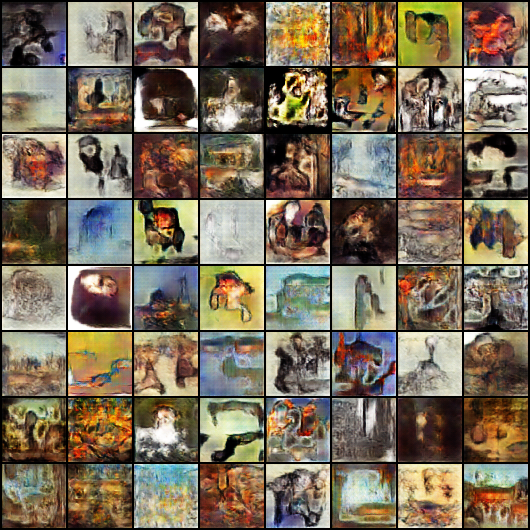

In [39]:
Image('./generated/generated-images-0089.png')

In [40]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'avi / AVI (Audio Video Interleaved)'
OpenCV: FFMPEG: fallback to use tag 0x34504d46/'FMP4'


In [42]:
losses_g, losses_d, real_scores, fake_scores = history

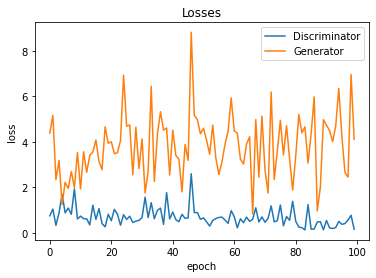

In [43]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

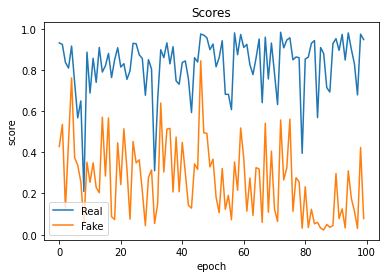

In [44]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');